## 获取和读取数据

In [39]:
%matplotlib inline
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.8.1+cpu


In [3]:
train_data=pd.read_csv('Datasets/housePrices/train.csv')
test_data=pd.read_csv('Datasets/housePrices/test.csv')

In [4]:
train_data.shape

(1460, 81)

In [5]:
test_data.shape

(1459, 80)

In [6]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [8]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [10]:
all_features.shape

(2919, 79)

## 预处理数据

In [18]:
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
all_features=all_features.fillna(0)

In [20]:
all_features=pd.get_dummies(all_features,dummy_na=True)# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features.shape

(2919, 354)

In [21]:
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

## 训练模型

In [22]:
loss=torch.nn.MSELoss()
def get_net(feature_num):
    net=nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

In [23]:
def log_rmse(net,features,labels):
    with torch.no_grad():
        clipped_preds=torch.max(net(features),torch.tensor(1.0))
        rmse=torch.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

In [25]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optimizer=torch.optim.Adam(params=net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    net=net.float()
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

## 显示曲线

In [27]:
def semilogy(x_vals,y_vals,x_label,y_label,x2_vals=None,y2_vals=None,legend=None):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals,y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals,y2_vals,linestyle=':')
        plt.legend(legend)

## K折交叉验证

In [26]:
def get_k_fold_data(k,i,X,y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid

In [28]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net(X_train.shape[1])
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse',range(1,num_epochs+1),valid_ls,['train','valid'])
        print('fold %d,train rmse %f,valid rmse %f'%(i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

## 模型选择

fold 0,train rmse 0.177432,valid rmse 0.249644
fold 1,train rmse 0.166672,valid rmse 0.244233
fold 2,train rmse 0.169209,valid rmse 0.227694
fold 3,train rmse 0.176412,valid rmse 0.220847
fold 4,train rmse 0.159359,valid rmse 0.230819
5-fold validation:avg train rmse 0.169817,avg valid rmse 0.234648


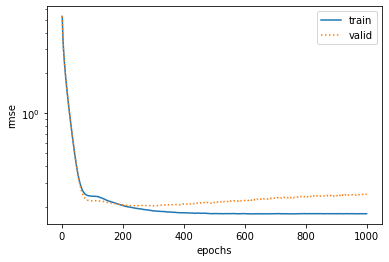

In [41]:
k,num_epochs,lr,weight_decay,batch_size=5,1000,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation:avg train rmse %f,avg valid rmse %f'%(k,train_l,valid_l))

## 预测并在KAGGLE提交结果

In [42]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net=get_net(train_features.shape[1])
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
    print('train rmse %f'%train_ls[-1])
    preds=net(test_features).detach().numpy()
    print(preds.shape)
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('./submission.csv',index=False)

train rmse 0.173193
(1459, 1)


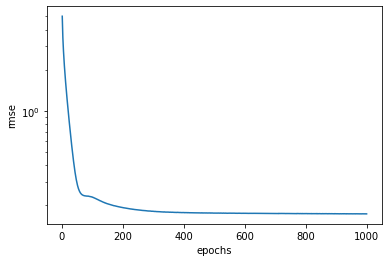

In [43]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)